In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import PercentFormatter

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Set parameters

In [15]:
simul_data = False
pm1_setting = False
animation = False # not available with +/-1 setting
animation_length = 30 # seconds

n = 1000
L = 100

if simul_data:
    T = 5*n
    p = 300
    mu_norm = 5

    if pm1_setting:
        k = 2
        pi = np.array([0.5, 0.5])
        mu = stats.norm.rvs(size=(p, 1))
        M = np.concatenate([+mu, -mu], axis=1)
    else:
        k = 3
        pi = np.array([0.334, 0.333, 0.333])
        M = stats.norm.rvs(size=(p, k))
    
    M = mu_norm*M/np.linalg.norm(M, axis=0)
    J = utils.getJ(T, pi)
    true_partition = np.argmax(J, axis=1)

    P = M@(J.T) # signal
    Z = stats.norm.rvs(size=(p, T)) # noise
    X = P+Z # observation
    
    get_data = lambda t: X[:, t]
else:
    file = 'data/'
    classes = ['collie', 'tabby']
    # classes = ['collie', 'siamese', 'tabby']
    k = len(classes)

    normalized_features = True # only with collie + tabby

    if normalized_features:
        features = [open(file+'{}_normalized.csv'.format(cl), 'r') for cl in classes]
    else:
        features = [open(file+'{}_features.csv'.format(cl), 'r') for cl in classes]

    p = len(features[0].readline().rstrip().split(' '))
    features[0].seek(0)
    
    cl_len = np.zeros(k, dtype=int)
    for i, f in enumerate(features):
        cl_len[i] = sum(1 for line in f)
        f.seek(0)

    T = np.sum(cl_len)

    true_partition = np.repeat(range(k), cl_len)
    np.random.shuffle(true_partition)
    get_data = lambda t: np.array(features[true_partition[t]].readline().rstrip().split(' '), dtype=float)

setting = "$T = {} \quad n = {} \quad p = {} \quad L = {}$".format(T, n, p, L)
if simul_data:
    setting += "$\quad || \mu || = {}$".format(mu_norm)

# The following parameters are only used in the general setting (curve fitting algorithm)
n_eigvecs = 5 # number of top empirical eigenvectors
idx_basis = [-1, -2, -3, -4, -5, -6, -7] # index of basis vectors

smooth_par = 0.15
h_start = 10*k
divided_warmup = True

basis = utils.basis(n, L, kind='toeplitz')[1][idx_basis]

# Streaming

In [16]:
if pm1_setting:
    class_count, details = utils.pm1_streaming(get_data, T, n, p, L, k)
    lbda, w, partition_ite, time_ite = details
else:
    class_count, details = utils.streaming(get_data, T, p, L, k, n_eigvecs, basis, smooth_par, h_start, divided_warmup)
    lbda, w, exp_smooth, partition0, curves, partition_ite, time_ite = details
partition = np.argmax(class_count, axis=1)

100%|██████████| 20000/20000 [25:40<00:00, 12.98it/s]


In [17]:
if not simul_data:
    for f in features:
        f.close()

# Show results

In [18]:
c_err, per, per_inv = utils.get_classif_error(k, partition, true_partition)
print("Classification error: {:.2%}".format(c_err))

delay_c_err = np.mean(per[partition_ite[n-1:]] != np.array([true_partition[t:t+n] for t in range(T-n+1)]), axis=0)[::-1]

Classification error: 8.18%


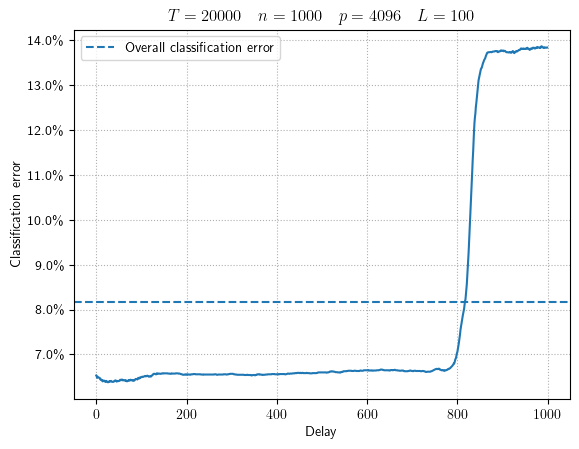

In [19]:
plt.plot(delay_c_err)
plt.axhline(y=c_err, ls='--', label="Overall classification error")
plt.grid(ls=':')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xlabel("Delay")
plt.ylabel("Classification error")
plt.title(setting)
plt.legend()
plt.show()

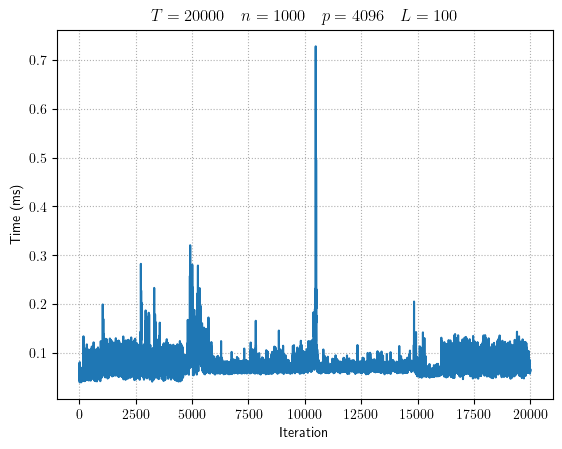

In [20]:
plt.plot(time_ite)
plt.grid(ls=':')
plt.xlabel("Iteration")
plt.ylabel("Time (ms)")
plt.title(setting)
plt.show()

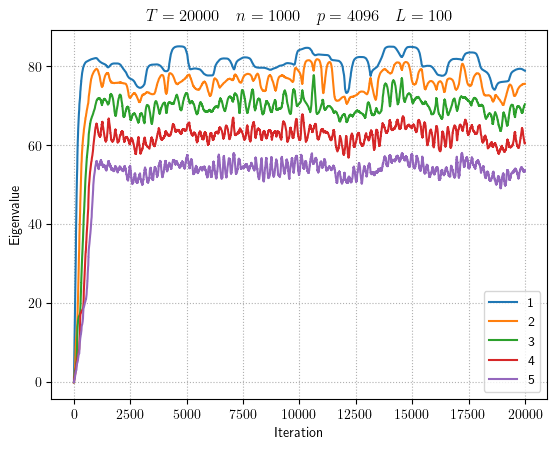

In [21]:
if pm1_setting:
    plt.plot(lbda, label=1)
else:
    for i in range(n_eigvecs):
        plt.plot(lbda[i], label=i+1)
plt.grid(ls=':')
plt.xlabel("Iteration")
plt.ylabel("Eigenvalue")
plt.title(setting)
plt.legend()
plt.show()

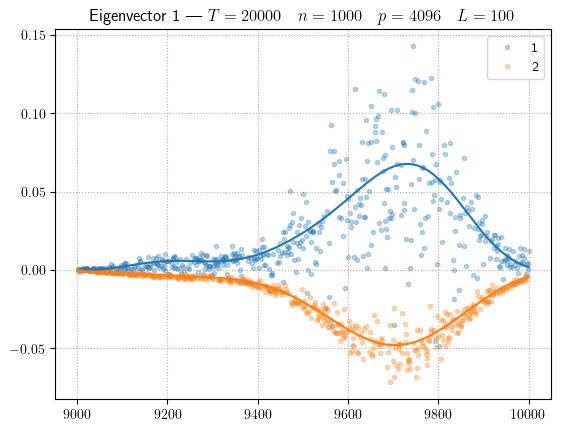

In [25]:
t = T//2
# t = n-1
i = 0

x = np.arange(max(0, t-n+1), max(n, t+1))
for j in range(k):
    color = 'C'+str(j)
    cl = (true_partition[max(0, t-n+1):t+1] == j)
    cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
    if pm1_setting:
        plt.plot(x[cl], w[t, cl], ls='', marker='.', c=color, label=j+1, zorder=2)
    else:
        plt.plot(x[cl], w[t, i, cl], ls='', marker='.', alpha=.3, c=color, label=j+1, zorder=2)
        if (divided_warmup and t <= n-1) or (not divided_warmup and t == n-1):
            mask = ((x <= t) & (partition0 == per_inv[j]))
            plt.plot(x[mask], exp_smooth[i, mask], ls='--', c=color, zorder=3)
        if t >= n-1:
            plt.plot(x, curves[t, per_inv[j], i], c=color, zorder=4)
plt.grid(ls=':')
plt.title("Eigenvector {} | ".format(1 if pm1_setting else i+1)+setting)
plt.legend()
plt.show()

In [23]:
if animation and (not pm1_setting):
    i = 0

    fig, ax = plt.subplots()

    for j in range(k):
        color = 'C'+str(j)
        ax.plot([], ls='', marker='.', label=j, c=color)
        ax.plot([], ls='--', c=color)
        ax.plot([], ls='-', c=color)
    ax.grid(ls=':')
    ax.set_title("Eigenvector {} | ".format(i+1)+setting)
    ax.legend()

    def animate(t):
        x = np.arange(max(0, t-n+1), max(n, t+1))
        ax.set_xlim(x[0], x[-1])
        ax.set_ylim((w[t, i].min(), w[t, i].max()))
        for j in range(k):
            cl = (true_partition[max(0, t-n+1):t+1] == j)
            cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
            ax.lines[3*j].set_data((x[cl], w[t, i, cl]))
            if (divided_warmup and t <= n-1) or (not divided_warmup and t == n-1):
                mask = ((x <= t) & (partition0 == per_inv[j]))
                ax.lines[3*j+1].set_data((x[mask], exp_smooth[i, mask]))
            if t >= n-1:
                ax.lines[3*j+2].set_data((x, curves[t, per_inv[j], i]))

    anim = FuncAnimation(fig, animate, frames=T, interval=animation_length*1000/T, repeat=False)
    anim.save("streaming.mp4")